In [1]:
import Interface
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np

%matplotlib inline
# This script illustrates how to test the SLM using a local (non-server interface)

cupy not installed. Using numpy.


### Example 1: Basic Computational Holography

In this example, we are able to set arbitrary targets, and calculate the phase pattern that will produce these targets. Note that targets can also specify an intensity pattern, which can be used to improve array uniformity. The interface to the slmsuite is called `SLMSuiteInterface`. There are also utilities like `get_phase`, `get_amp` and `get_farfield` which allows us to extract the slm phase, amplitude and farfield pattern. Note that farfield here means the post-lens image plane. Plotting utilities like `plot_slmplane` and `plot_farfield` also exist. 

In [2]:
iface = Interface.SLMSuiteInterface()
iface.set_SLM() # can put in a SLM as an argument. No argument uses the default virtual SLM
iface.set_camera() # Same here, use a default virtual camera. Default camera has 1024 x 1024 pixels

computational_space = (2048,2048) # Space in which to do a calculation

In [3]:
# the target lives in the (1024,1024) camera space if a camera is provided, otherwise it lives in the computational k-space.
# How you want to create this is of course up to you
ntargets = 2
targets = np.zeros((2,ntargets))
targets[0,:] = np.array([500,600]) # x-coordinates of the targets
targets[1,:] = np.array([500,700]) # y-coordinates of the targets

In [4]:
iface.calculate(computational_space, targets)

  5%|▌         | 1/20 [00:01<00:29,  1.53s/it]C:\ProgramFiles\Python39\lib\site-packages\slmsuite\holography\algorithms.py:1010: RuntimeWarning: invalid value encountered in divide
  cp.divide(farfield, cp.abs(farfield), out=farfield)
100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


(None, None, 1)

In [5]:
# Manually get the slm_plane and far_field amp. Both are complex
slm_phase = iface.get_phase()
slm_amp = iface.get_amp()
far_field_amp = iface.get_farfield()

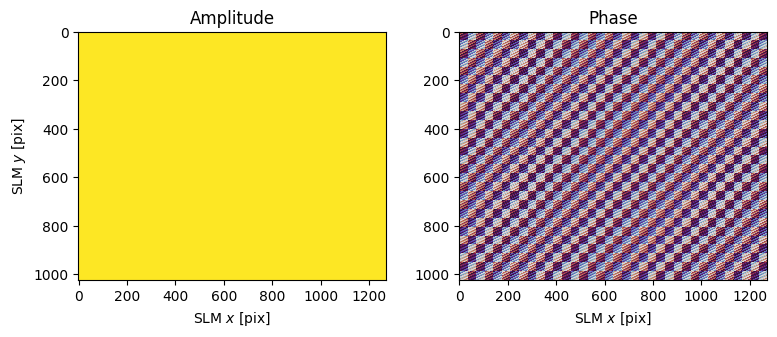

0

In [5]:
# Plot using tools from slmsuite
iface.plot_slmplane()

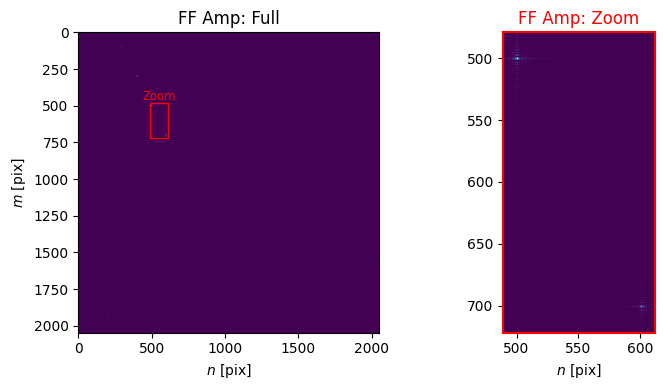

0

In [6]:
# Plot using tools from slmsuite
iface.plot_farfield()

### Specifying different target amplitudes.

`calculate` also accepts different amplitudes for each spot. This is useful for intensity feedback.

100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


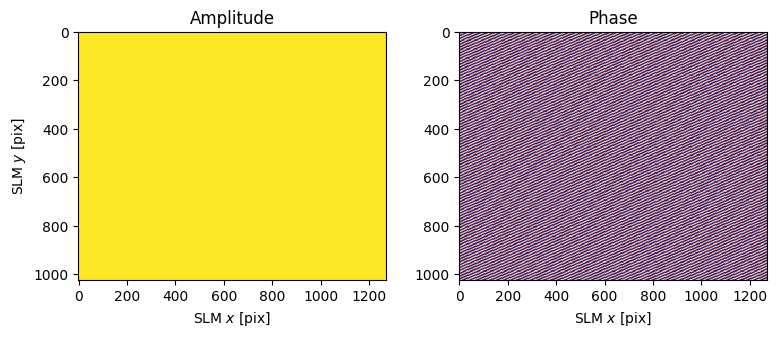

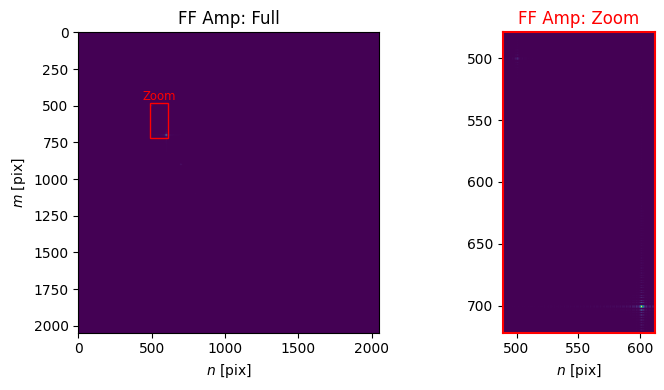

0

In [8]:
# We can also specify different target amplitudes to change the amplitudes of the two spots
target_amps = np.array([1, 10]) # One spot is 10 times larger. User does not need to normalize.
iface.calculate(computational_space, targets, target_amps)

# Plot using tools from slmsuite
iface.plot_slmplane()

# Plot using tools from slmsuite
iface.plot_farfield()

100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


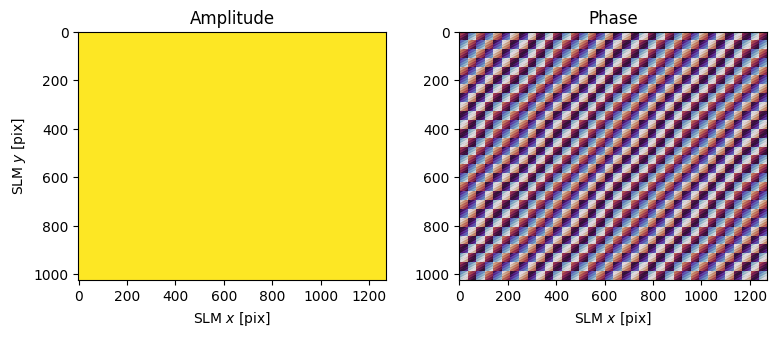

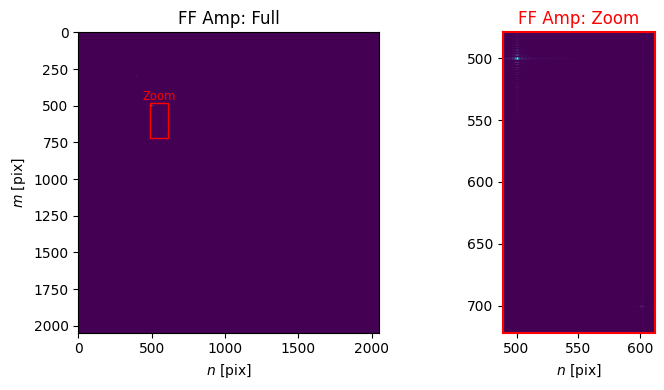

0

In [9]:
# Change which one is brighter
target_amps = np.array([10, 1]) # One spot is 10 times larger. User does not need to normalize.
iface.calculate(computational_space, targets, target_amps)

# Plot using tools from slmsuite
iface.plot_slmplane()

# Plot using tools from slmsuite
iface.plot_farfield()

### Saving Results

A `save_options` dict can be used to specify the conditions for saving details about a calculation. In general, a config file is saved as a `.yml` file for human readability. Any phase pattern or record of the intended farfield pattern is saved in a compressed `npz` file. The `npz` file is readout with `np.load` as a dict

In [7]:
# We can also save our result by using some functionality from utils. 
save_options = dict()
save_options["config"] = True # This option saves the configuration of this run of the algorithm
save_options["slm_pattern"] = True # This option saves the slm phase pattern and amplitude pattern (the amplitude pattern is not calculated. So far, the above have assumed a constant amplitude and we have not described functionality to change this)
save_options["ff_pattern"] = True # This option saves the far field amplitude pattern
save_options["target"] = True # This option saves the desired target
#save_options["path"] = 'INSERT PATH' # Enable this to save to a desired path. By default it is the current working directory
save_options["name"] = 'tutorial' # This name will be used in the path.
#save_options["prefix"] = 'INSERT PREFIX' # By default, the prefix is the day and time. This is to make every save unique.
save_options["crop"] = True # This option crops the slm pattern to the slm, instead of an array the shape of the computational space size.

extra_data = dict() # This is a generic struct that allows you to save other pieces of information
extra_data["test"] = "This is the tutorial!"

config_path, data_path, err = iface.save_calculation(save_options, extra_data)

In [ ]:
# We can read out the config using the yaml library
import yaml

with open(config_path, 'r') as file:
    config_dict = yaml.load(file, Loader=yaml.FullLoader)
config_dict # This is a dictionary where you can now read out whatever parameter you want

In [ ]:
# To read out the data file, we need to use np.load
data_dict = np.load(data_path)
data_dict

In [ ]:
# Let's compare the ff_amp and target. Note slm_amp and slm_phase may be cropped
print(data_dict["slm_phase"].shape)
np.all(data_dict["ff_amp"] == iface.get_farfield())

### Specifying different SLM amplitudes

Typically, the SLM is not uniformly illuminated. We can use `set_slm_amplitude` to specify an illumination pattern. 

In [10]:
# We create a slm amplitude in numpy. 
width = iface.slm.shape[1] # number of columns
height = iface.slm.shape[0] # number of rows

xpix = (width - 1) *  np.linspace(-.5, .5, width)
ypix = (height - 1) * np.linspace(-.5, .5, height)

x_grid, y_grid = np.meshgrid(xpix, ypix)

waist = 500 # Gaussian waist in pixels
gaussian_amp = np.exp(-(np.square(x_grid) + np.square(y_grid)) * (1 / waist ** 2))

iface.set_slm_amplitude(gaussian_amp)
iface.calculate(computational_space, targets, target_amps)

100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


(None, None, 1)

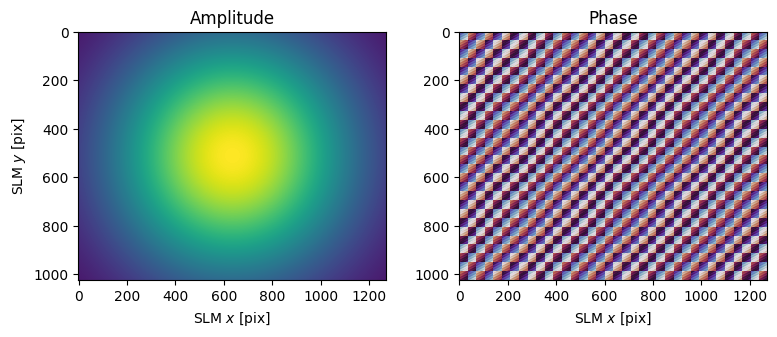

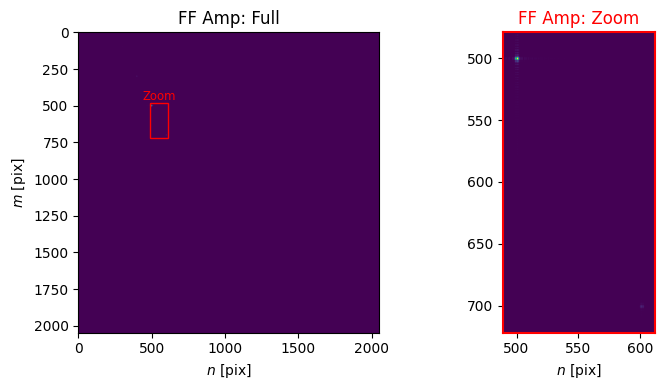

0

In [11]:
# Plot using tools from slmsuite
iface.plot_slmplane()

# Plot using tools from slmsuite
iface.plot_farfield()

### Adding Zernike polynomials and other phase patterns

We can add zernike polynomials and other phase patterns. The functions `zernike`, `zernike_sum` and `lens` from `slmsuite` are wrapped by the functions `get_zernike_phase`, `get_zernike_sum_phase`, `get_lens_phase`. These functions return a SLM phase pattern that is of the size of the SLM and ready to be summed over the phase generated by a hologram and returned from `get_phase`. The functions `plot_farfield` and `plot_slmplane` can be also be used to visualize these phases, that are not from the algorithm. Note that `get_slmplane` is weird, because the program assumes that a Fourier transform is still the relationship between the slm and farfield planes, but this is NOT true.

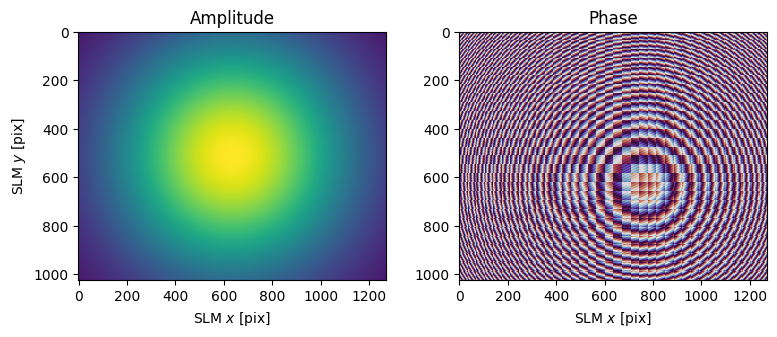

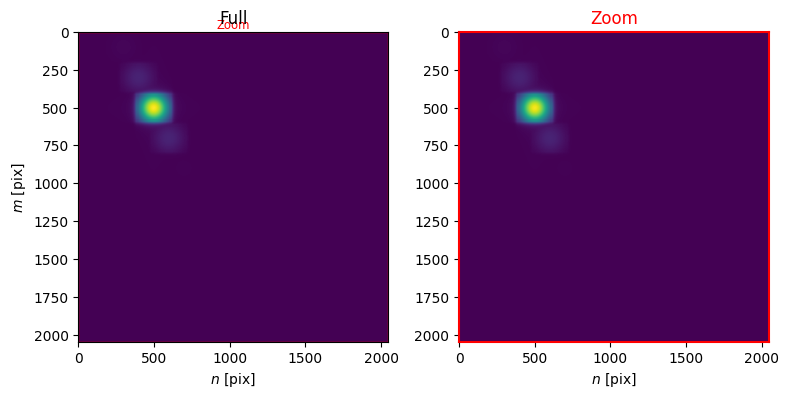

0

In [21]:
# We add a lens to the previous calculation
optimized_phase = iface.get_phase()
lens,_ = iface.get_lens_phase(1e4)

tot_phase = optimized_phase + lens

iface.plot_slmplane(phase=tot_phase)
iface.plot_farfield(phase=tot_phase)

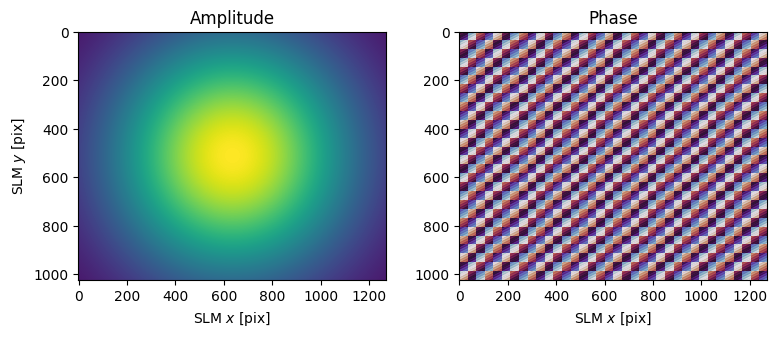

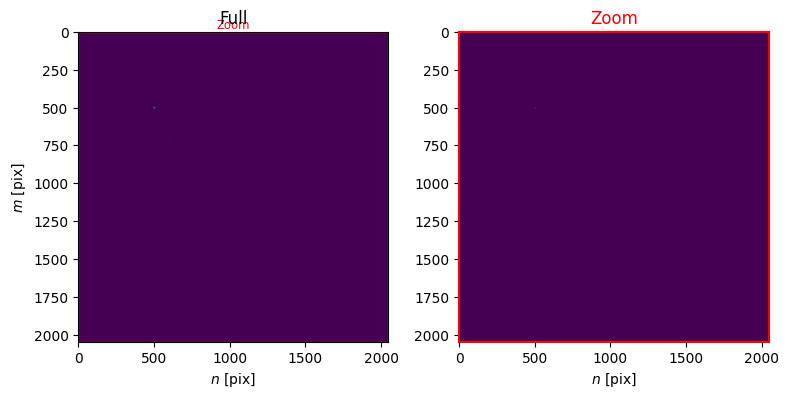

0

In [31]:
# Add a Zernike polynoimal
# We add a lens to the previous calculation
optimized_phase = iface.get_phase()
aberr,_ = iface.get_zernike_phase(1,1)

tot_phase = optimized_phase + 10 * aberr

iface.plot_slmplane(phase=tot_phase)
iface.plot_farfield(phase=tot_phase)